In [ ]:
%%capture
!pip install torchmetrics
!pip install pytorch-warmup

In [ ]:
#Important imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import albumentations as A
import torch
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
from torchmetrics.functional.classification import multiclass_roc, multiclass_auroc
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve
import torchvision.transforms.v2 as tfs
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
#from time import sleep -- optional, practice for debugging
import torchmetrics
from matplotlib.gridspec import GridSpec
import random
import pytorch_warmup as warmup

In [ ]:
#activating cuda to accelerate processes
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#ensuring accelerator had been activated
!nvidia-smi

Wed Nov 26 08:31:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             47W /  400W |    2321MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataDir='/content/drive/MyDrive/Eye'

In [ ]:
#hyperparameters for model training
config = {
    "lr_rate": 5e-3,
    "momentum": 0.9,
    "epochs": 20,
    "num_classes": 4,
    "batch_size": 16,
    "weight_decay": 3e-3,
    "seed": 42,

    "scheduler": {
        "mode": "max",
        "min_lr": 3e-4,
        "patience": 3,
        "threshold": 0.001,
        "warmup_epochs": 5,
        "max_lr": 1e-3
    }
}


In [ ]:
#Ensuring reproducibility
def set_seed(seed):
  torch.manual_seed(seed)
  torch.random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = False
  torch.backends.cudnn.benchmark = True

In [ ]:

def build_df(root):
    filepaths, labels = [], []

    for label in os.listdir(root):
        folder = os.path.join(root, label)

        for fname in os.listdir(folder):
            filepaths.append(os.path.join(folder, fname))
            labels.append(label)

    return pd.DataFrame({"Filepath": filepaths, "Label": labels})


def split_df(df):
    train_df, temp_df = train_test_split(
        df, test_size=0.2, stratify=df["Label"], random_state=42, shuffle=True
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df["Label"], random_state=42, shuffle=True
    )
    return train_df, val_df, test_df


train_transforms = A.Compose([
    A.Resize(height=300, width=300),
    A.RandomCrop(height = 300, width = 300, scale=(0.8, 1.0)),
    A.HorizontalFlip(p = 0.5),
    A.GaussianBlur(blur_limit=(1, 3)),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2()
])


test_transforms = A.Compose([
    A.Resize(height=300, width=300),
    A.CenterCrop(height=300, width=300),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2()
])



class ImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(df["Label"].unique())
        self.class_to_idx = {class_name : idx for idx, class_name in enumerate(self.classes)}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["Filepath"]).convert("RGB")
        img_np = np.array(img)
        transformed_img = self.transform(image=img_np)
        label = self.class_to_idx[row["Label"]]
        return transformed_img['image'], label


def create_loaders(train_df, val_df, test_df, batch_size= config['batch_size']):
    train_set = ImageDataset(train_df, train_transforms)
    val_set = ImageDataset(val_df, test_transforms)
    test_set = ImageDataset(test_df, test_transforms)
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
        DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True))

df = build_df(dataDir)
train_df, val_df, test_df = split_df(df)
train_loader, val_loader, test_loader = create_loaders(train_df, val_df, test_df)

# **Exploratory Data Analysis**

In [ ]:


def show_image(df):
  fig = plt.figure(figsize=(20,20))
  gs = GridSpec(4,4, figure = fig)
  classes = df.Label.unique()
  for ind, cat in enumerate(classes):
    filepaths = df[df["Label"] == cat]["Filepath"].values[:4]
    for r, filepath in enumerate(filepaths):
      ax = fig.add_subplot(gs[ind, r])
      ax.imshow(plt.imread(filepath))
      ax.axis("off")
      ax.set_title(cat, fontsize=20, loc='center', pad=10)
  plt.tight_layout()
  plt.show()


In [ ]:
df.sample(5)

Filepath                 Label
3523  /content/drive/MyDrive/Eye/glaucoma/Glaucoma_0...              glaucoma
945   /content/drive/MyDrive/Eye/diabetic_retinopath...  diabetic_retinopathy
1818   /content/drive/MyDrive/Eye/normal/3184_right.jpg                normal
2267  /content/drive/MyDrive/Eye/cataract/2209_left.jpg              cataract
660   /content/drive/MyDrive/Eye/diabetic_retinopath...  diabetic_retinopathy

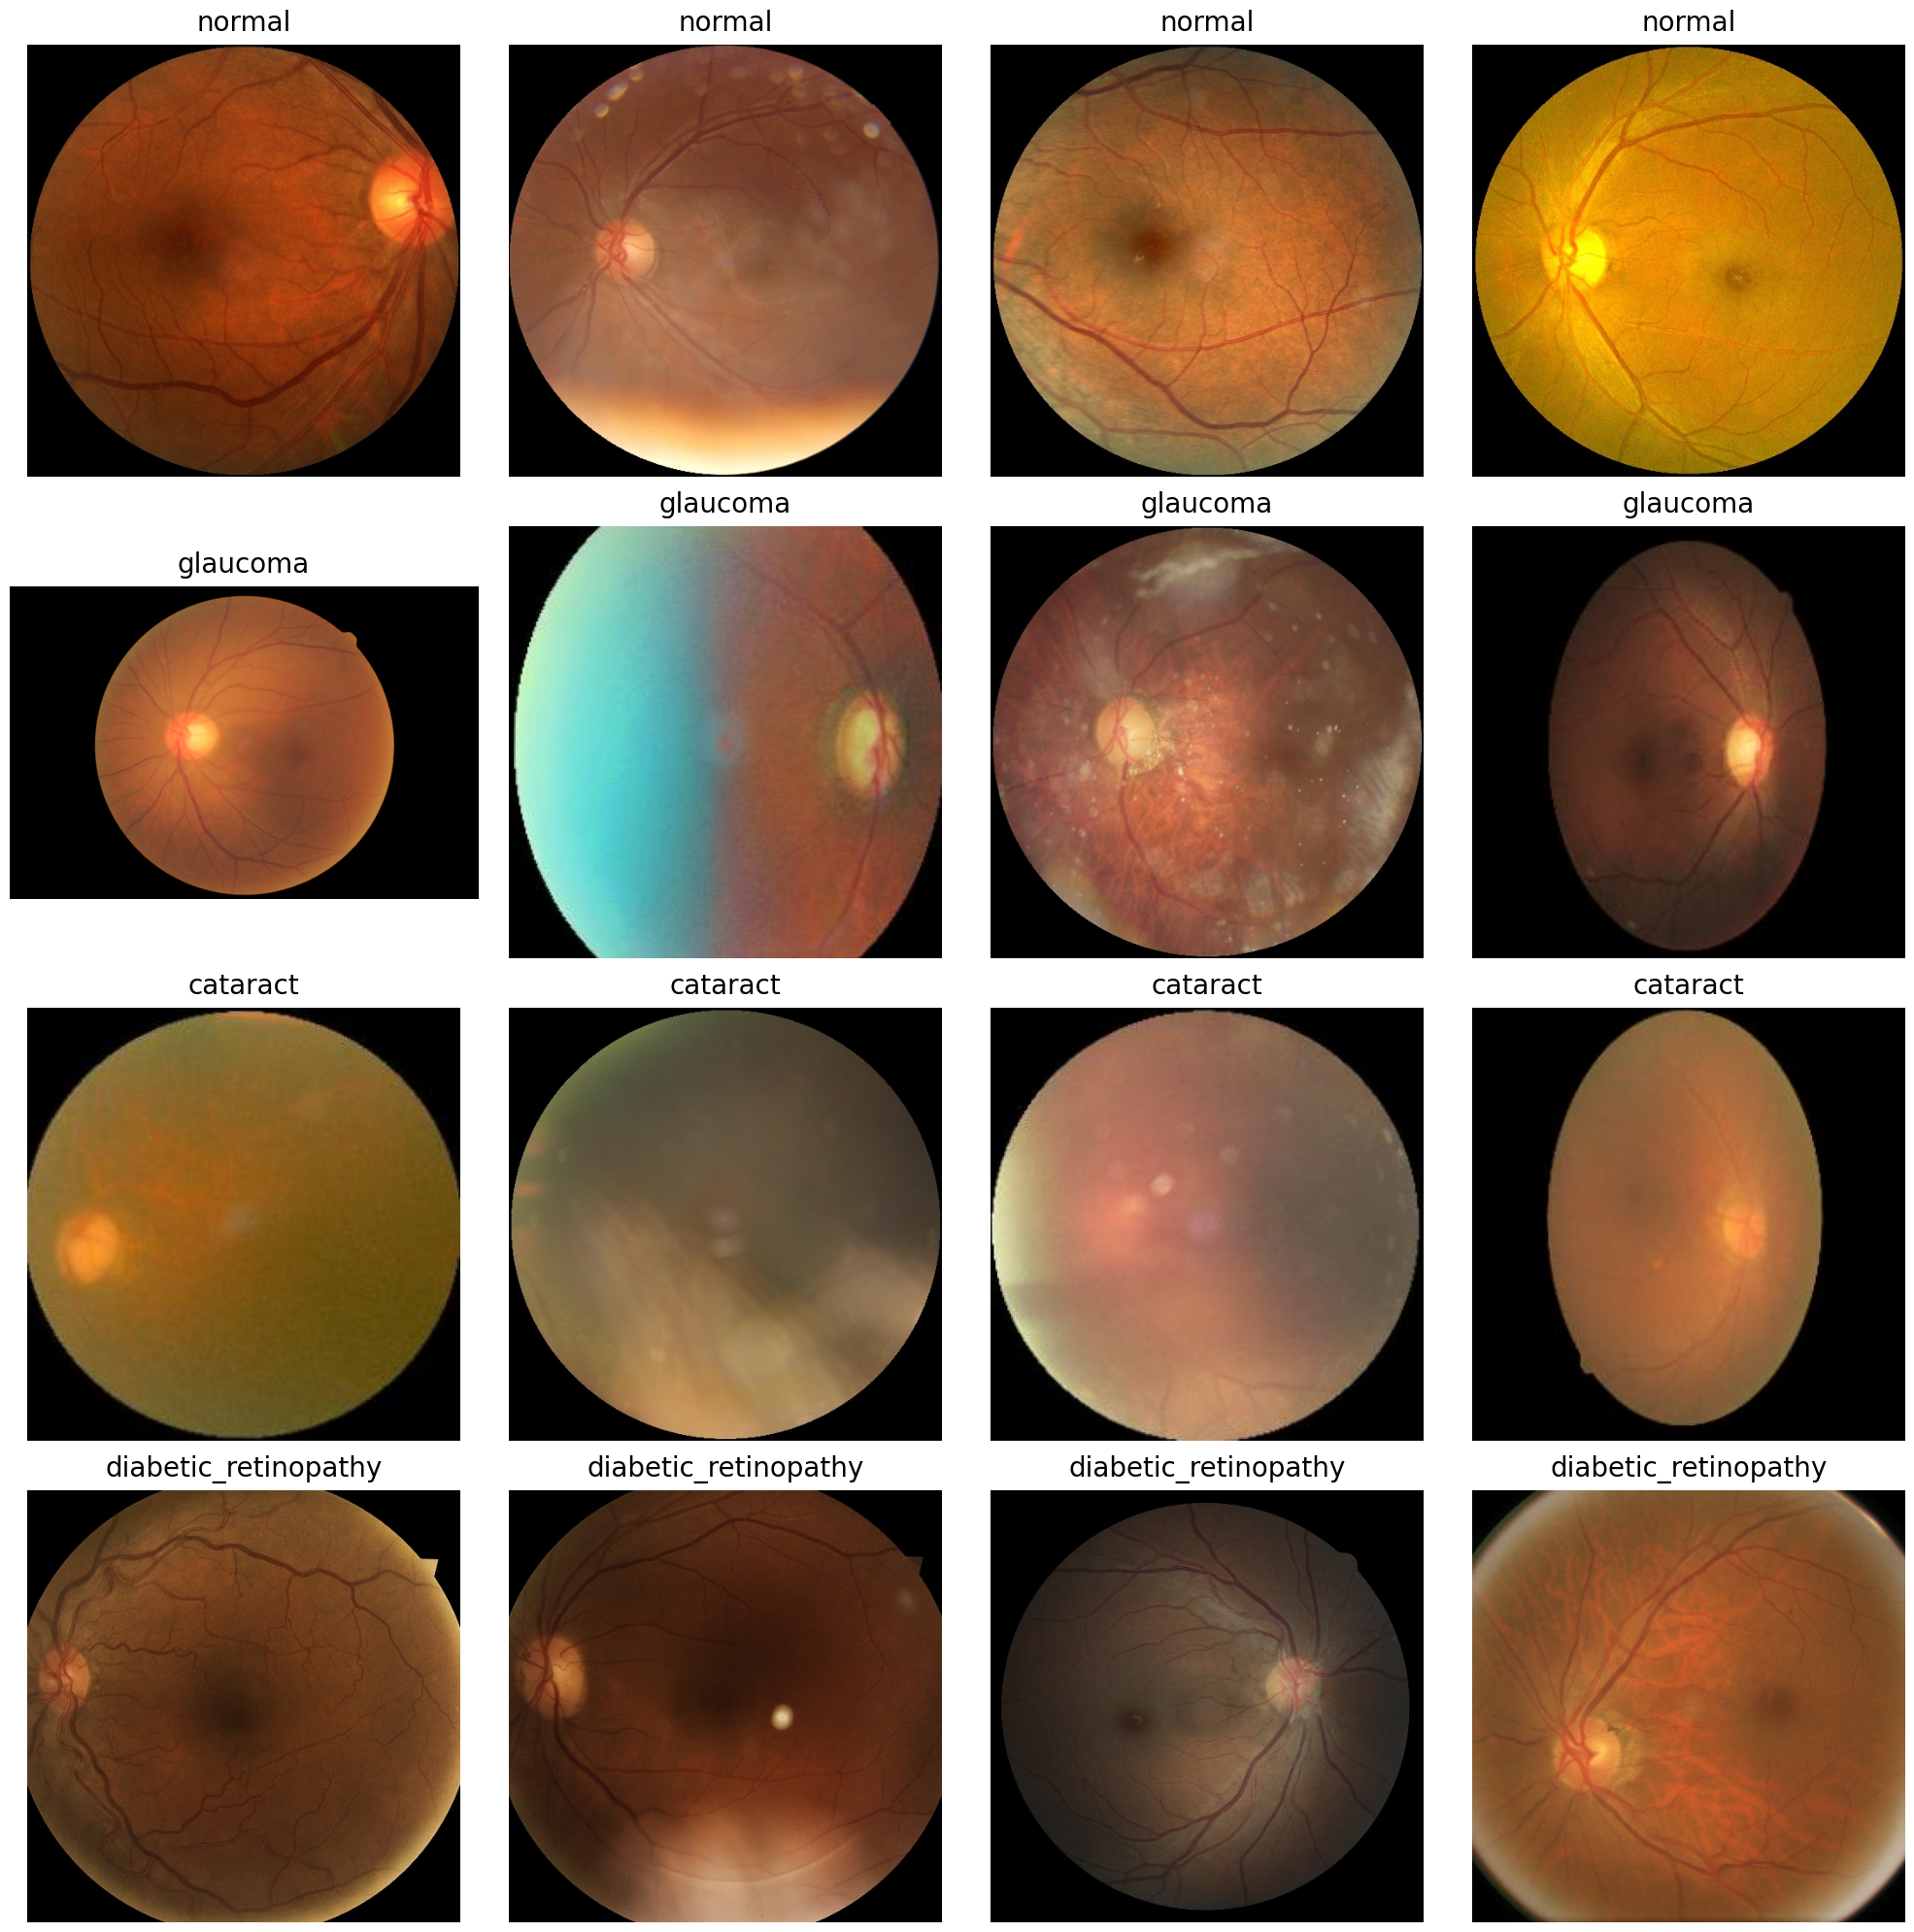

In [ ]:
show_image(train_df)

In [ ]:
def plot_class_distribution(df):
  classes = df["Label"].unique()
  cs = df["Label"].value_counts()
  height = df["Label"].value_counts()
  fig, ax = plt.subplots()
  bar = plt.bar(classes, height)
  plt.bar_label(bar, cs)
  plt.title(f"Class distribution comparison \n total: {df.value_counts().sum()}")
  plt.xticks(rotation = 45)
  plt.ylabel("Class size")
  plt.xlabel("Classes")
  plt.show()



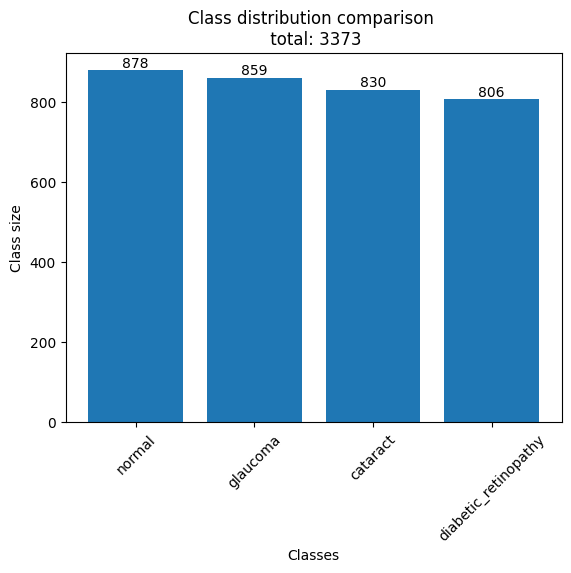

In [ ]:
plot_class_distribution(train_df)

# **Initialize the model**

In [ ]:
def build_model(num_classes, freeze=True):

    weight = models.EfficientNet_B3_Weights.DEFAULT
    model = models.efficientnet_b3(weights=weight)
    f_num = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(f_num, num_classes)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False

        for param in model.classifier[1].parameters():
            param.requires_grad = True

    model = model.to(device)
    return model


In [ ]:
model = build_model(4)

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["lr_rate"],
    weight_decay=config["weight_decay"],
    #momentum=config["momentum"] -- if Nadam or SGDwMomentum
    )

loss_fn = nn.CrossEntropyLoss()

acc = torchmetrics.Accuracy(task="multiclass", num_classes=config["num_classes"]).to(device)
val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=config["num_classes"]).to(device)
test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=config["num_classes"]).to(device)


steps_per_epoch = len(train_df) // config["batch_size"]

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=config["max_lr"],
#     steps_per_epoch = steps_per_epoch,
#     epochs = config["epochs"]
# ) -- could use OneCycle instead


sch = config["scheduler"]

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=sch["mode"],
    min_lr=sch["min_lr"],
    patience=sch["patience"],
    threshold=sch["threshold"]
)



## **Model Training**

In [ ]:
def evaluation(model, metric, loader, loss_fn):
    model.eval()
    metric.reset()
    valid_loss = 0.0
    total_batches = 0.0
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            predictions = model(X_batch)
            losses = loss_fn(predictions, y_batch)

            valid_loss += losses.item()
            total_batches += 1

            metric.update(predictions, y_batch)

            y_pred.append(predictions.cpu())
            y_true.append(y_batch.cpu())

    parameters = {
        "metric": metric.compute(),
        "valid_loss": valid_loss / total_batches if total_batches != 0 else 0.0,
        "y_true": y_true,
        "y_pred": y_pred,
    }
    return parameters


def model_training(model, optimizer, loss_fn,
                   train_data, val_data,
                   metric, val_metric,
                   epochs, scheduler,
                   scheduler_on=True, clipping=True):

    history = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": [],
        "y_true": [],
        "y_pred": [],
    }

    sch = config["scheduler"]
    warmup_epochs = sch["warmup_epochs"]
    base_lr = config["lr_rate"]


    def set_lr(lr_value):
        for g in optimizer.param_groups:
            g["lr"] = lr_value

    for epoch in range(epochs):
        model.train()
        losses = 0.0
        metric.reset()

        if epoch < warmup_epochs:

            warmup_factor = (epoch + 1) / warmup_epochs
            current_lr = base_lr * max(0.1, warmup_factor)
            set_lr(current_lr)

        for X_batch, y_batch in tqdm(train_data):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()

            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            optimizer.step()

            losses += loss.item()
            metric.update(predictions, y_batch)

            history["y_pred"].append(predictions.detach().cpu())
            history["y_true"].append(y_batch.detach().cpu())


        val = evaluation(model, val_metric, val_data, loss_fn)


        if scheduler_on and epoch >= warmup_epochs:
            scheduler.step(val["valid_loss"])

        history["train_loss"].append(losses / len(train_data))
        history["train_acc"].append(metric.compute().item())
        history["valid_loss"].append(val["valid_loss"])
        history["valid_acc"].append(val["metric"])

        print(f"epoch: {epoch+1} / {epochs}", flush=True)
        print(
            f"train_loss/accuracy: {history['train_loss'][-1]:.5f}/"
            f"{history['train_acc'][-1]:.4f}",
            flush=True,
        )
        print(
            f"valid_loss/accuracy: {history['valid_loss'][-1]:.5f}/"
            f"{history['valid_acc'][-1]:.4f}",
            flush=True,
        )

    return history


In [ ]:
history = model_training(model, optimizer, loss_fn = loss_fn, train_data = train_loader, val_data = val_loader, metric = acc, val_metric=val_acc, epochs = config['epochs'], scheduler = lr_scheduler)

100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


epoch: 1 / 20
train_loss/accuracy: 0.88121/0.6522
valid_loss/accuracy: 0.68648/0.7464


100%|██████████| 211/211 [00:14<00:00, 14.71it/s]


epoch: 2 / 20
train_loss/accuracy: 0.68292/0.7287
valid_loss/accuracy: 0.57060/0.7962


100%|██████████| 211/211 [00:14<00:00, 14.78it/s]


epoch: 3 / 20
train_loss/accuracy: 0.63892/0.7468
valid_loss/accuracy: 0.52566/0.7986


100%|██████████| 211/211 [00:13<00:00, 15.32it/s]


epoch: 4 / 20
train_loss/accuracy: 0.63092/0.7584
valid_loss/accuracy: 0.47658/0.8341


100%|██████████| 211/211 [00:14<00:00, 14.61it/s]


epoch: 5 / 20
train_loss/accuracy: 0.63770/0.7530
valid_loss/accuracy: 0.51454/0.8389


100%|██████████| 211/211 [00:14<00:00, 15.04it/s]


epoch: 6 / 20
train_loss/accuracy: 0.62588/0.7539
valid_loss/accuracy: 0.53156/0.8009


100%|██████████| 211/211 [00:13<00:00, 15.09it/s]


epoch: 7 / 20
train_loss/accuracy: 0.61027/0.7693
valid_loss/accuracy: 0.49148/0.8294


100%|██████████| 211/211 [00:13<00:00, 15.13it/s]


epoch: 8 / 20
train_loss/accuracy: 0.65328/0.7551
valid_loss/accuracy: 0.46434/0.8270


100%|██████████| 211/211 [00:13<00:00, 15.21it/s]


epoch: 9 / 20
train_loss/accuracy: 0.64039/0.7560
valid_loss/accuracy: 0.49491/0.8246


100%|██████████| 211/211 [00:14<00:00, 14.58it/s]


epoch: 10 / 20
train_loss/accuracy: 0.64478/0.7566
valid_loss/accuracy: 0.44483/0.8460


100%|██████████| 211/211 [00:14<00:00, 15.01it/s]


epoch: 11 / 20
train_loss/accuracy: 0.56640/0.7848
valid_loss/accuracy: 0.42023/0.8578


100%|██████████| 211/211 [00:14<00:00, 14.81it/s]


epoch: 12 / 20
train_loss/accuracy: 0.55355/0.7827
valid_loss/accuracy: 0.43107/0.8555


100%|██████████| 211/211 [00:14<00:00, 14.71it/s]


epoch: 13 / 20
train_loss/accuracy: 0.55253/0.7833
valid_loss/accuracy: 0.42524/0.8531


100%|██████████| 211/211 [00:13<00:00, 15.51it/s]


epoch: 14 / 20
train_loss/accuracy: 0.57387/0.7732
valid_loss/accuracy: 0.40457/0.8531


100%|██████████| 211/211 [00:14<00:00, 14.54it/s]


epoch: 15 / 20
train_loss/accuracy: 0.53716/0.7877
valid_loss/accuracy: 0.43435/0.8436


100%|██████████| 211/211 [00:14<00:00, 14.58it/s]


epoch: 16 / 20
train_loss/accuracy: 0.53809/0.7880
valid_loss/accuracy: 0.42184/0.8602


100%|██████████| 211/211 [00:13<00:00, 15.08it/s]


epoch: 17 / 20
train_loss/accuracy: 0.54192/0.7877
valid_loss/accuracy: 0.41581/0.8649


100%|██████████| 211/211 [00:14<00:00, 15.03it/s]


epoch: 18 / 20
train_loss/accuracy: 0.52769/0.7919
valid_loss/accuracy: 0.41754/0.8649


100%|██████████| 211/211 [00:14<00:00, 14.81it/s]


epoch: 19 / 20
train_loss/accuracy: 0.53212/0.7898
valid_loss/accuracy: 0.40405/0.8626


100%|██████████| 211/211 [00:14<00:00, 14.39it/s]


epoch: 20 / 20
train_loss/accuracy: 0.54890/0.7836
valid_loss/accuracy: 0.42447/0.8649


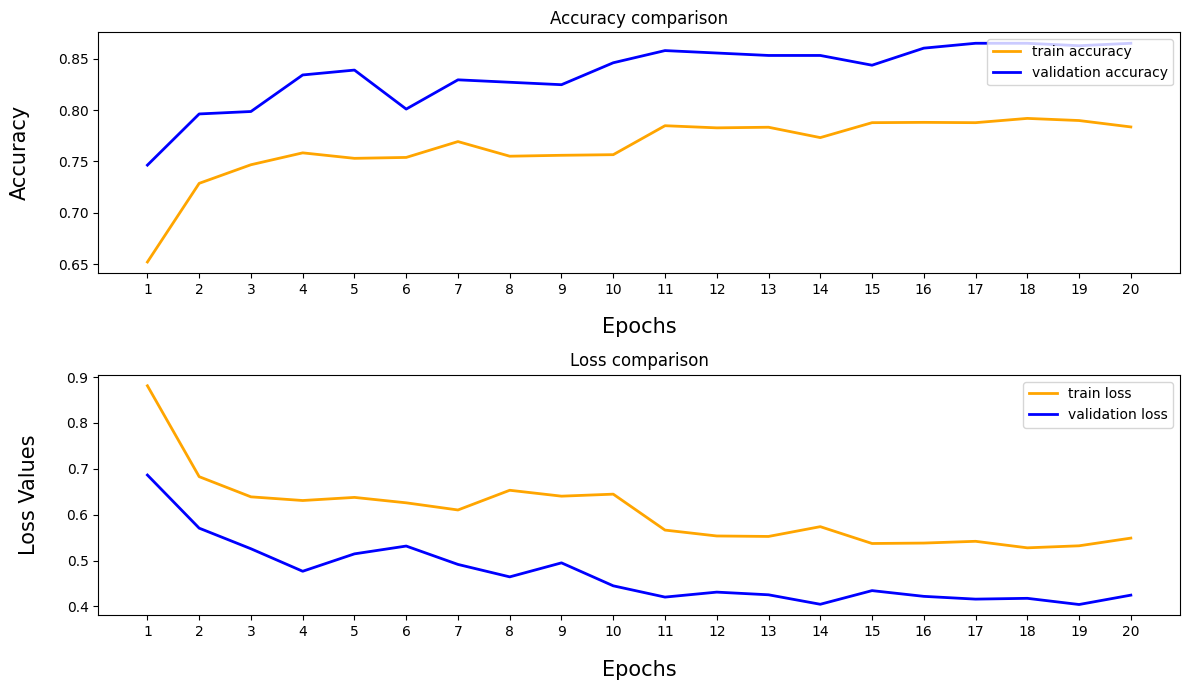

In [ ]:
def plot_result_comparison(history):

  font = {'family': 'sans-serif',
        'color':  'black',
        'size': 15,
        }

  valid_acc_cpu = [t.cpu() for t in history["valid_acc"]]


  x = np.arange(1, len(history["train_acc"]) + 1)

  fig, (ax_acc, ax_loss) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,7), tight_layout = True)

  # Plotting Accuracy
  ax_acc.plot(x, history["train_acc"], linewidth = 2, markersize = 12, color = "orange", label = "train accuracy")
  ax_acc.plot(x, valid_acc_cpu, linewidth = 2, markersize = 12, color = "blue", label = "validation accuracy")

  ax_acc.set_xlabel("Epochs", labelpad = 15, fontdict = font)
  ax_acc.set_ylabel("Accuracy", labelpad = 20, fontdict = font)
  ax_acc.set_title("Accuracy comparison")
  ax_acc.legend(loc = "upper right")
  ax_acc.set_xticks(np.arange(min(x), max(x)+1, 1.0))

  # Plotting Loss
  ax_loss.plot(x, history["train_loss"], linewidth =  2, markersize = 12, color = "orange", label = "train loss")
  ax_loss.plot(x, history["valid_loss"], linewidth = 2, markersize = 12, color = "blue", label = "validation loss")

  ax_loss.set_xlabel("Epochs", labelpad = 15, fontdict = font)
  ax_loss.set_ylabel("Loss Values", labelpad = 20, fontdict = font)
  ax_loss.set_title("Loss comparison")
  ax_loss.legend(loc = "upper right")
  ax_loss.set_xticks(np.arange(min(x), max(x)+1, 1.0))



  plt.show()

plot_result_comparison(history)

<Figure size 1200x800 with 0 Axes>

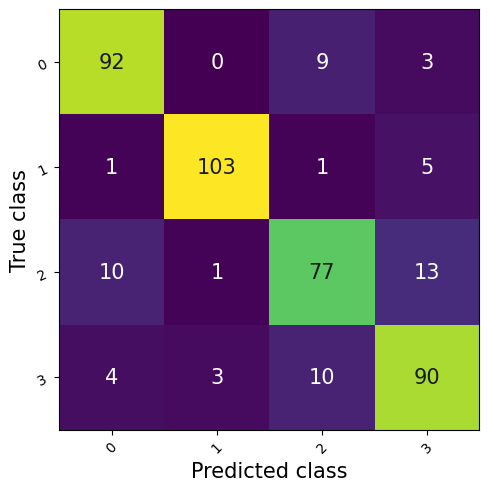

In [ ]:
def show_confusion_matrix(preds, target):

   fig = plt.figure(figsize = (12,8))
   metric = MulticlassConfusionMatrix(num_classes=4)
   preds_tensor = torch.cat(preds)
   target_tensor = torch.cat(target)
   metric.update(preds_tensor, target_tensor)
   fig_, ax_ = metric.plot()
   plt.show()


show_confusion_matrix(test["y_pred"], test["y_true"])

In [ ]:
test = evaluation(model, test_acc, test_loader, loss_fn)

In [ ]:
def print_classification_report(y_pred_list, y_true_list):

    y_pred_np = np.concatenate([t.argmax(dim=1).cpu().detach().numpy() for t in y_pred_list])
    y_true_np = np.concatenate([t.cpu().detach().numpy() for t in y_true_list])

    report = classification_report(y_true_np, y_pred_np, output_dict=True)
    df = pd.DataFrame(report).T
    return df
print_classification_report(test["y_pred"], test["y_true"])

precision    recall  f1-score    support
0              0.859813  0.884615  0.872038  104.00000
1              0.962617  0.936364  0.949309  110.00000
2              0.793814  0.762376  0.777778  101.00000
3              0.810811  0.841121  0.825688  107.00000
accuracy       0.857820  0.857820  0.857820    0.85782
macro avg      0.856764  0.856119  0.856203  422.00000
weighted avg   0.858390  0.857820  0.857868  422.00000

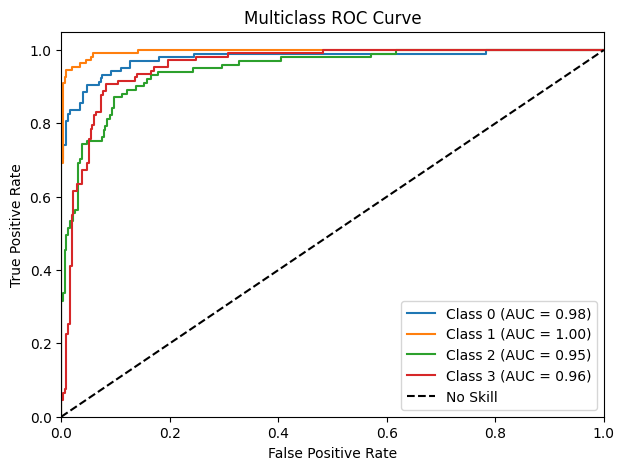

In [ ]:
def print_multiclass_rocauc(preds, target):

    preds_tensor = torch.cat(preds)
    target_tensor = torch.cat(target)


    fpr, tpr, thresholds = multiclass_roc(
        preds_tensor,
        target_tensor,
        num_classes=config["num_classes"],
        average=None,
    )

    aurocs = multiclass_auroc(
        preds_tensor,
        target_tensor,
        num_classes=config["num_classes"],
        average=None,
    )

    plt.figure(figsize=(7, 5))
    for c in range(config["num_classes"]):
        plt.plot(fpr[c], tpr[c], label=f'Class {c} (AUC = {aurocs[c]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend()
    plt.show()

print_multiclass_rocauc(test["y_pred"], test["y_true"])